## EyeON: Eye on Operational Networks
### a firmware inventory/threat analysis tool


In [1]:
from eyeon import observe
from pprint import pprint

### Objects
EyeON consists of two parts - an `observe` call and a `parse` call. `observe` works on a single file to return a suite of identifying metrics. `parse` calls `observe` recursively, returning an observation for each file in a directory. Both of these can be run either from a library import or a `CLI` command.

In [2]:
obs = observe.Observe("./tests/Obsidian.1.1.9.exe")
ols = observe.Observe("./tests/ls")

### Data Standard
Depending on the file type, e.g. PE or ELF, different observations will be collected. 
For instance, PE files typically contain more metadata and have signature information.

In [10]:
for key, val in obs.signatures["signatures"].items():
    for cert in val["certs"]:
        for dat in cert.split("\n"):
            print(dat)

cert. version     : 3
serial number     : 48:FC:93:B4:60:55:94:8D:36:A7:C9:8A:89:D6:94:16
issuer name       : C=GB, ST=Greater Manchester, L=Salford, O=Comodo CA Limited, CN=AAA Certificate Services
subject name      : C=GB, O=Sectigo Limited, CN=Sectigo Public Code Signing Root R46
issued  on        : 2021-05-25 00:00:00
expires on        : 2028-12-31 23:59:59
signed using      : RSA with SHA-384
RSA key size      : 4096 bits
basic constraints : CA=true
key usage         : Digital Signature, Key Cert Sign, CRL Sign
ext key usage     : Code Signing
certificate policies : Any Policy, ???

cert. version     : 3
serial number     : 0E:9B:18:8E:F9:D0:2D:E7:EF:DB:50:E2:08:40:18:5A
issuer name       : C=US, O=DigiCert Inc, OU=www.digicert.com, CN=DigiCert Assured ID Root CA
subject name      : C=US, O=DigiCert Inc, OU=www.digicert.com, CN=DigiCert Trusted Root G4
issued  on        : 2022-08-01 00:00:00
expires on        : 2031-11-09 23:59:59
signed using      : RSA with SHA-384
RSA key size 

In [8]:
val

{'certs': ['cert. version     : 3\nserial number     : 48:FC:93:B4:60:55:94:8D:36:A7:C9:8A:89:D6:94:16\nissuer name       : C=GB, ST=Greater Manchester, L=Salford, O=Comodo CA Limited, CN=AAA Certificate Services\nsubject name      : C=GB, O=Sectigo Limited, CN=Sectigo Public Code Signing Root R46\nissued  on        : 2021-05-25 00:00:00\nexpires on        : 2028-12-31 23:59:59\nsigned using      : RSA with SHA-384\nRSA key size      : 4096 bits\nbasic constraints : CA=true\nkey usage         : Digital Signature, Key Cert Sign, CRL Sign\next key usage     : Code Signing\ncertificate policies : Any Policy, ???\n',
  'cert. version     : 3\nserial number     : 0E:9B:18:8E:F9:D0:2D:E7:EF:DB:50:E2:08:40:18:5A\nissuer name       : C=US, O=DigiCert Inc, OU=www.digicert.com, CN=DigiCert Assured ID Root CA\nsubject name      : C=US, O=DigiCert Inc, OU=www.digicert.com, CN=DigiCert Trusted Root G4\nissued  on        : 2022-08-01 00:00:00\nexpires on        : 2031-11-09 23:59:59\nsigned using   

In [1]:
import lief
import networkx as nx

In [18]:
G = nx.DiGraph(name="Signing Certs")
label_dict = {}
sample_cert = None


In [19]:
#for root, dirs, files in os.walk(exe):
# for file in os.listdir(exe):
#    path = root.split(os.sep)
#    print((len(path) - 1) * '---', os.path.basename(root))
#   for file in files:
#    print(len(path) * '---', file)
file = "Obsidian.1.1.9.exe"
pe = lief.parse(f"tests/{file}")
# for sig in pe.signatures:
sig = pe.signatures[0]
for crt in sig.certificates:
# print(crt)
# Write cert (in DER format)
    with open(f"tests/outputs/{crt.subject}.crt", "wb") as binary_file:
      binary_file.write(crt.raw)
    # Add to graph
    try:
      G.add_nodes_from([crt.subject,crt.issuer])
      G.add_edge(crt.subject,crt.issuer)
      label_dict[crt.subject]=crt.subject
      G.add_nodes_from([crt.subject,crt.issuer])
      G.add_edge(crt.subject,crt.issuer)
    except nx.NetworkXError:
      print('Yikes!')
      print(crt.subject)
      print(crt.issuer)
    spl = str(crt.subject).split(', ')
    subj = {}
    for i in spl:
        j = i.split("=")
        try:
            subj[j[0]] = j[1]
        except:
            print(j)
            subj[j[0]] = ""
    print(crt.subject)
    print(subj)


C=GB, O=Sectigo Limited, CN=Sectigo Public Code Signing Root R46
{'C': 'GB', 'O': 'Sectigo Limited', 'CN': 'Sectigo Public Code Signing Root R46'}
C=US, O=DigiCert Inc, OU=www.digicert.com, CN=DigiCert Trusted Root G4
{'C': 'US', 'O': 'DigiCert Inc', 'OU': 'www.digicert.com', 'CN': 'DigiCert Trusted Root G4'}
C=CA, ST=Ontario, O=Dynalist Inc, CN=Dynalist Inc
{'C': 'CA', 'ST': 'Ontario', 'O': 'Dynalist Inc', 'CN': 'Dynalist Inc'}
C=GB, O=Sectigo Limited, CN=Sectigo Public Code Signing CA R36
{'C': 'GB', 'O': 'Sectigo Limited', 'CN': 'Sectigo Public Code Signing CA R36'}
['Inc.']
C=US, O=DigiCert\, Inc., CN=DigiCert Trusted G4 RSA4096 SHA256 TimeStamping CA
{'C': 'US', 'O': 'DigiCert\\', 'Inc.': '', 'CN': 'DigiCert Trusted G4 RSA4096 SHA256 TimeStamping CA'}
C=US, O=DigiCert, CN=DigiCert Timestamp 2022 - 2
{'C': 'US', 'O': 'DigiCert', 'CN': 'DigiCert Timestamp 2022 - 2'}


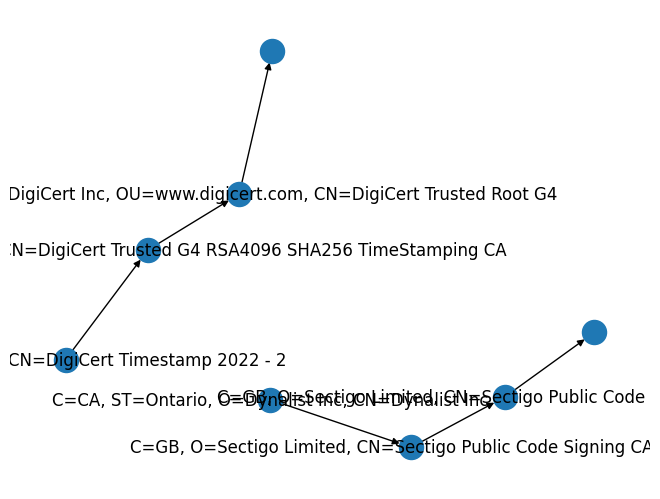

In [20]:
nx.draw_spring(G,with_labels=True, labels=label_dict, )


In [6]:
# %pip install matplotlib

In [22]:
G.in_degree

InDegreeView({'C=GB, O=Sectigo Limited, CN=Sectigo Public Code Signing Root R46': 1, 'C=GB, ST=Greater Manchester, L=Salford, O=Comodo CA Limited, CN=AAA Certificate Services': 1, 'C=US, O=DigiCert Inc, OU=www.digicert.com, CN=DigiCert Trusted Root G4': 1, 'C=US, O=DigiCert Inc, OU=www.digicert.com, CN=DigiCert Assured ID Root CA': 1, 'C=CA, ST=Ontario, O=Dynalist Inc, CN=Dynalist Inc': 0, 'C=GB, O=Sectigo Limited, CN=Sectigo Public Code Signing CA R36': 1, 'C=US, O=DigiCert\\, Inc., CN=DigiCert Trusted G4 RSA4096 SHA256 TimeStamping CA': 1, 'C=US, O=DigiCert, CN=DigiCert Timestamp 2022 - 2': 0})

In [10]:
spl = str(crt.subject).split(',')
subj = {}
for i in spl:
    j = i.split("=")
    subj[j[0]] = j[1]


In [11]:
subj

{'C': 'US', ' O': 'DigiCert', ' CN': 'DigiCert Timestamp 2022 - 2'}

In [17]:
help(nx.draw_networkx)

Help on function draw_networkx in module networkx.drawing.nx_pylab:

draw_networkx(G, pos=None, arrows=None, with_labels=True, **kwds)
    Draw the graph G using Matplotlib.
    
    Draw the graph with Matplotlib with options for node positions,
    labeling, titles, and many other drawing features.
    See draw() for simple drawing without labels or axes.
    
    Parameters
    ----------
    G : graph
        A networkx graph
    
    pos : dictionary, optional
        A dictionary with nodes as keys and positions as values.
        If not specified a spring layout positioning will be computed.
        See :py:mod:`networkx.drawing.layout` for functions that
        compute node positions.
    
    arrows : bool or None, optional (default=None)
        If `None`, directed graphs draw arrowheads with
        `~matplotlib.patches.FancyArrowPatch`, while undirected graphs draw edges
        via `~matplotlib.collections.LineCollection` for speed.
        If `True`, draw arrowheads with